In [1]:
import sys
import os
sys.path.append('/root/GanLuo/PullSum_MNIST/CIFAR10实验_arxiv')
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import argparse
from resnet_model import new_ResNet18,old_ResNet18
import time
import pickle
import os
import numpy as np

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  #先四周填充0，在吧图像随机裁剪成32*32
    transforms.RandomHorizontalFlip(),  #图像一半的概率翻转，一半的概率不翻转
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), #R,G,B每层的归一化用到的均值和方差
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Randomly crop the image with padding
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(15),  # Random rotation between -15 and 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change brightness, contrast, saturation, and hue
    transforms.RandomGrayscale(p=0.1),  # Convert the image to grayscale with a probability of 0.1
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalize using dataset statistics
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [5]:
trainset = torchvision.datasets.CIFAR10(root='/root/GanLuo/PullSum_MNIST/CIFAR10实验_arxiv/cifar-10-python/cifar-10-batches-py', train=True, download=False, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='/root/GanLuo/PullSum_MNIST/CIFAR10实验_arxiv/cifar-10-python/cifar-10-batches-py', train=False, download=False, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

In [3]:
EPOCH = 20   
BATCH_SIZE = 128      
LR = 1e-2       
Milestones=[135,185]
Debug=False

In [13]:
# 模型定义-ResNet
net = new_ResNet18().to(device)
# 定义损失函数和优化方式
criterion = nn.CrossEntropyLoss()  #损失函数为交叉熵，多用于多分类问题
optimizer = optim.SGD(net.parameters(), lr=LR)  # 优化方式
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=Milestones, gamma=0.1)

#writer = SummaryWriter("./logs")

best_acc = 85  # 初始化最佳测试准确率
print("Start Training, Resnet-18!")

EPOCH=100

Train_Accuracy=[]
Train_Loss=[]
Test_Accuracy=[]
Test_Loss=[]

for epoch in range(EPOCH):
    train_loss = 0.0
    train_accu = 0.0
    val_loss = 0.0
    val_accu = 0.0

    scheduler.step()
    net.train()
    sum_loss = 0.0
    correct = 0.0
    total = 0
    begin = time.time()

    # 训练阶段
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # forward + backward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        sum_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()

        if Debug:
            print("[Epoch:{}/{}, Batch:{}/{}] Loss: {:.3f} | Acc: {:.3f}%".format(epoch + 1, EPOCH, i + 1, int(len(trainset) / BATCH_SIZE), sum_loss / (i + 1), 100. * correct / total))

    train_loss = sum_loss / int(len(trainset) / BATCH_SIZE)
    train_accu = 100. * correct / total

    Train_Accuracy.append(train_accu)
    Train_Loss.append(train_loss)

    # 测试阶段
    with torch.no_grad():
        sum_loss = 0.0
        correct = 0.0
        total = 0
        for data in testloader:
            net.eval()
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            sum_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += predicted.eq(labels.data).cpu().sum()

    val_loss = sum_loss / int(len(testset) / BATCH_SIZE)
    val_accu = 100. * correct / total
    Test_Accuracy.append(val_accu)
    Test_Loss.append(val_loss)
    end = time.time()

    # 打印和记录每轮结果
    print("[Epoch:{}/{}] Train Loss: {:.3f} | Train Acc: {:.3f}% Test Loss: {:.3f} | Test Acc: {:.3f}% Cost time: {:.2f} min".format(epoch + 1, EPOCH, train_loss, train_accu, val_loss, val_accu, (end - begin) / 60.0))



    # 保存模型
    #torch.save(net.state_dict(), './net_%03d.pth' % (epoch + 1))

    # 更新最佳准确率
    if val_accu > best_acc:
        with open("best_acc.txt", "w") as f3:
            f3.write("EPOCH=%d,best_acc= %.3f%%" % (epoch + 1, val_accu))
        best_acc = val_accu

print("Training Finished, Total EPOCH=%d" % EPOCH)


Start Training, Resnet-18!


/root/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/root/miniconda3/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[Epoch:1/100] Train Loss: 1.843 | Train Acc: 31.466% Test Loss: 2.070 | Test Acc: 39.430% Cost time: 0.27 min
[Epoch:2/100] Train Loss: 1.542 | Train Acc: 43.270% Test Loss: 1.766 | Test Acc: 49.700% Cost time: 0.27 min
[Epoch:3/100] Train Loss: 1.364 | Train Acc: 50.550% Test Loss: 1.723 | Test Acc: 52.000% Cost time: 0.26 min
[Epoch:4/100] Train Loss: 1.224 | Train Acc: 56.188% Test Loss: 1.882 | Test Acc: 52.030% Cost time: 0.26 min
[Epoch:5/100] Train Loss: 1.117 | Train Acc: 60.390% Test Loss: 1.287 | Test Acc: 63.850% Cost time: 0.27 min
[Epoch:6/100] Train Loss: 1.044 | Train Acc: 62.990% Test Loss: 1.300 | Test Acc: 65.790% Cost time: 0.27 min
[Epoch:7/100] Train Loss: 0.972 | Train Acc: 65.532% Test Loss: 1.168 | Test Acc: 68.310% Cost time: 0.27 min
[Epoch:8/100] Train Loss: 0.915 | Train Acc: 67.646% Test Loss: 1.085 | Test Acc: 70.870% Cost time: 0.26 min
[Epoch:9/100] Train Loss: 0.860 | Train Acc: 69.834% Test Loss: 1.101 | Test Acc: 70.910% Cost time: 0.27 min
[Epoch:10/

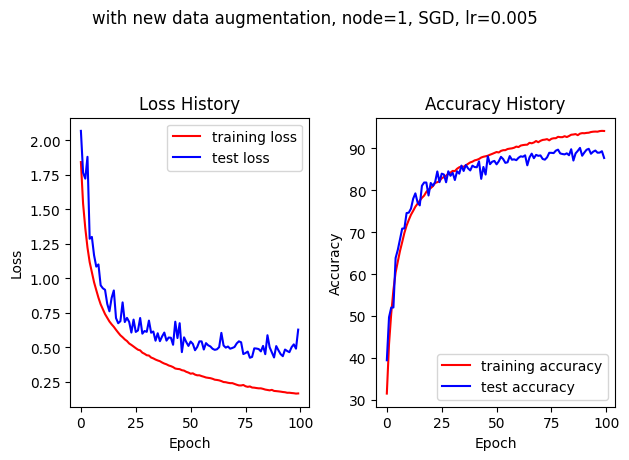

In [14]:
import matplotlib.pyplot as plt
from statistics import mean

plt.subplot(1,2,1)
plt.plot(Train_Loss,color='r',label='training loss')
plt.plot(Test_Loss,color='b',label='test loss')
plt.legend()
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(Train_Accuracy,color='r',label='training accuracy')
plt.plot(Test_Accuracy,color='b',label='test accuracy')
plt.legend()
plt.title('Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.suptitle(f'with new data augmentation, node=1, SGD, lr={LR}')
plt.tight_layout(rect=[0, 0.03, 1, 0.90])
plt.show()

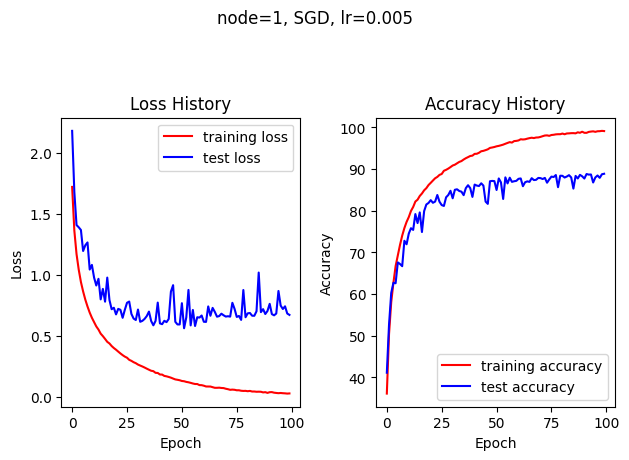

In [19]:
import matplotlib.pyplot as plt
from statistics import mean

plt.subplot(1,2,1)
plt.plot(Train_Loss,color='r',label='training loss')
plt.plot(Test_Loss,color='b',label='test loss')
plt.legend()
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(Train_Accuracy,color='r',label='training accuracy')
plt.plot(Test_Accuracy,color='b',label='test accuracy')
plt.legend()
plt.title('Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.suptitle(f'node=1, SGD, lr={LR}')
plt.tight_layout(rect=[0, 0.03, 1, 0.90])
plt.show()

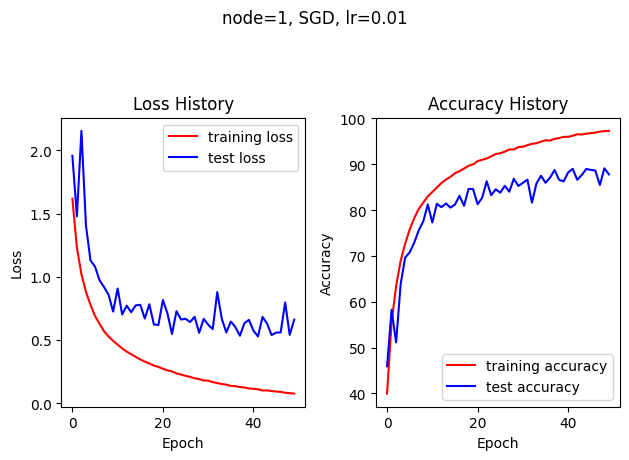

In [17]:
import matplotlib.pyplot as plt
from statistics import mean

plt.subplot(1,2,1)
plt.plot(Train_Loss,color='r',label='training loss')
plt.plot(Test_Loss,color='b',label='test loss')
plt.legend()
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(Train_Accuracy,color='r',label='training accuracy')
plt.plot(Test_Accuracy,color='b',label='test accuracy')
plt.legend()
plt.title('Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.suptitle(f'node=1, SGD, lr={LR}')
plt.tight_layout(rect=[0, 0.03, 1, 0.90])
plt.show()